`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   

In [7]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# расширение watermark для вывода информации о версиях пакетов
#  https://github.com/rasbt/watermark
# установка: командная строка - pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга   
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, бэггинг, случайный лес, бустинг, дерево регрессии  
*Данные*: `in-vehicle-coupon-recommendation.csv`. Источник: [сайт Калифорнийского университета в Ирвине](https://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation)

In [9]:
# выводим информацию о версиях python и пакетов
%watermark -a "Stepan Shilkin" -d -v -p numpy,pandas,matplotlib,sklearn 

Author: Stepan Shilkin

Python implementation: CPython
Python version       : 3.7.0
IPython version      : 7.34.0

numpy     : 1.21.6
pandas    : 1.1.5
matplotlib: 3.5.3
sklearn   : 0.0



# Указания к выполнению


## Загружаем пакеты

In [10]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [12]:
# константы
#  ядро для генератора случайных чисел
my_seed = 24
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [13]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Набор данных можно загрузить напрямую по ссылке: <https://raw.githubusercontent.com/ania607/ML/main/data/in-vehicle-coupon-recommendation.csv>. Справочник к данным доступен по адресу: <https://github.com/ania607/ML/blob/main/data/CodeBook_in-vehicle-coupon-recommendation.md>.    

Загружаем данные во фрейм и выясняем их размерность. В таблице много строк, поэтому для экономии времени загрузку сделаем в два шага: сначала скачаем таблицу и сохраним в папку `'./data'`, затем прочитаем её во фрейм. Перед скачиванием проверим, нет ли уже такого файла в папке с данными.  

In [14]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/winequality-red_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [15]:
# типы столбцов
DF_raw.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Y                         int64
dtype: object

Проблема в том, что, судя по справочнику к данным, все столбцы таблицы являются категориальными. Однако некоторые (бинарные) воспринимаются как `int`, а остальные как `object`. Посмотрим на столбцы типа `int`.   

In [16]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

,quality,Y
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
5,5,0
6,5,0


Отложим 15% наблюдений для прогноза.  

In [18]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

In [19]:
# выбрасываем стобцы с большинством пропусков или с нулевой дисперсией
#  из обучающей выборки
DF = DF.drop(['quality'], axis=1)
#  и из отложенных наблюдений
DF_predict = DF_predict.drop(['quality'], axis=1)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()`.   

Ещё раз оценим количество пропусков.  

In [20]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [21]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 5)

1    0.53863
0    0.46137
Name: Y, dtype: float64

In [22]:
# описательные статистики
DF.iloc[:, :].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.334952,0.527531,0.271847,2.519536,0.087394,15.786240,45.640177,0.996746,3.310545,0.657756,10.436019,0.538631
std,1.754752,0.179187,0.195595,1.359899,0.046124,10.517418,32.426949,0.001883,0.156791,0.168617,1.063541,0.498689
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995580,3.200000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,37.000000,0.996740,3.310000,0.620000,10.200000,1.000000
75%,9.300000,0.640000,0.430000,2.600000,0.091000,21.000000,60.000000,0.997860,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,0.790000,15.400000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.900000,1.000000


In [23]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропусков нет.  

## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [24]:
for col in DF.columns[:8] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

free_sulfur_dioxide и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.2205


Интересный результат: полное совпадение p-значений – объясняется тем, что на самом деле `direction_same` и `direction_opp` противоположны друг другу. Связь между ними функциональная: если направление на ресторан/кофейню, в который предлагается купон, не совпадает с направлением на исходное место назначения (`direction_same == 0`), то оно противоположно (`direction_opp == 1`), и наоборот. Поэтому в модель имеет смысл включать только одну из этих переменных.   

## Перекодировка номинальной и порядковой шкалы   

Перекодировка не треубуется так как исходные данные уже заходированы.   

In [25]:
# чтобы меньше исправлять
DF_num = DF

# результат
DF_num.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
694,9.0,0.470,0.31,2.70,0.084,24.0,125.0,0.99840,3.31,0.61,9.4,0
1300,5.2,0.645,0.00,2.15,0.080,15.0,28.0,0.99444,3.78,0.61,12.5,1
1351,7.2,0.620,0.01,2.30,0.065,8.0,46.0,0.99332,3.32,0.51,11.8,1
1246,7.4,0.740,0.07,1.70,0.086,15.0,48.0,0.99502,3.12,0.48,10.0,0
1206,7.2,0.360,0.46,2.10,0.074,24.0,44.0,0.99534,3.40,0.85,11.0,1


In [26]:
# чтоб меньше исправлять
DF_predict_num = DF_predict

# результат
DF_predict_num.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
18,7.4,0.59,0.08,4.4,0.086,6.0,29.0,0.9974,3.38,0.50,9.0,0
21,7.6,0.39,0.31,2.3,0.082,23.0,71.0,0.9982,3.52,0.65,9.7,0
24,6.9,0.40,0.14,2.4,0.085,21.0,40.0,0.9968,3.43,0.63,9.7,1


# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [27]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

202

In [28]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

20

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [29]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5, scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.756


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [30]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 122
Энтропия листьев для первых 5 значений alpha: [0.         0.00147167 0.00294334 0.00441501 0.00588668]


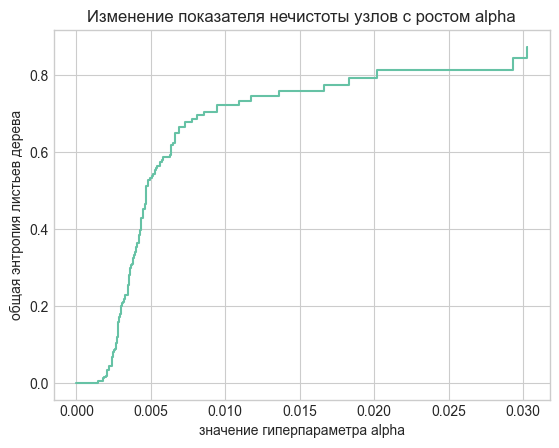

In [31]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [32]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 0.85 секунд


In [33]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 0.37 секунд


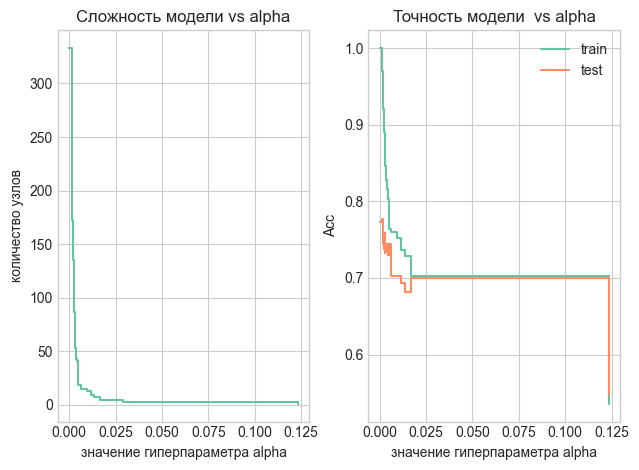

In [34]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [35]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 13,
 13,
 9,
 7,
 5,
 5,
 5,
 3,
 3,
 1]

In [36]:
plot_tree?

Количество узлов: 19 
Точность дерева на тестовой: 0.744


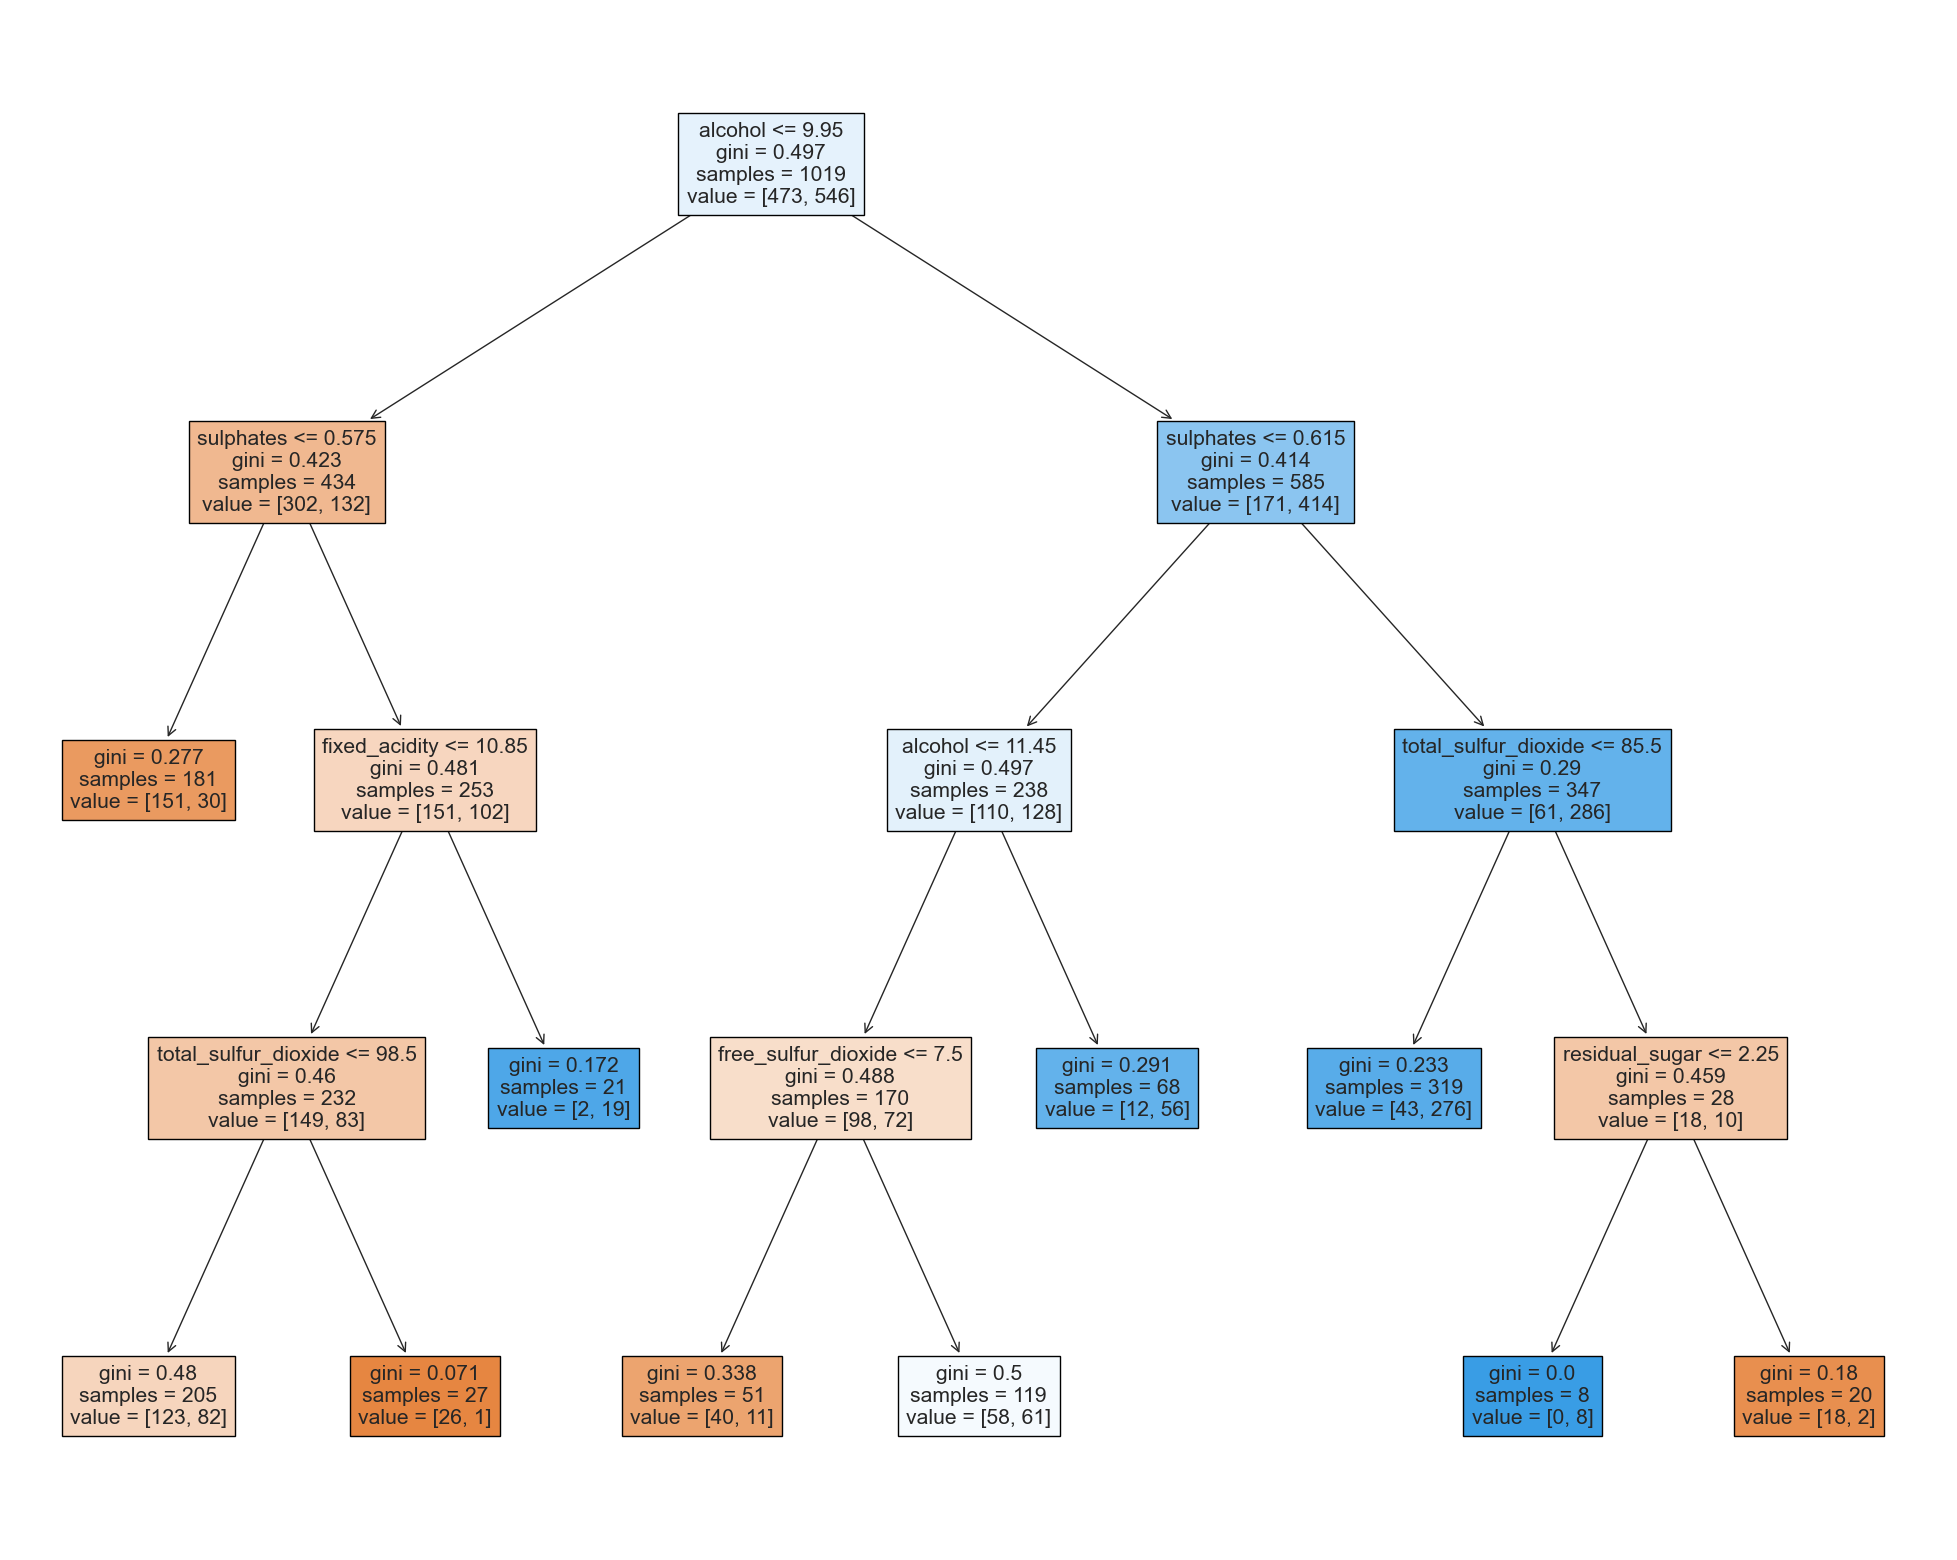

In [37]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 19
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [38]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- alcohol <= 9.95
|   |--- sulphates <= 0.57
|   |   |--- class: 0
|   |--- sulphates >  0.57
|   |   |--- fixed_acidity <= 10.85
|   |   |   |--- total_sulfur_dioxide <= 98.50
|   |   |   |   |--- class: 0
|   |   |   |--- total_sulfur_dioxide >  98.50
|   |   |   |   |--- class: 0
|   |   |--- fixed_acidity >  10.85
|   |   |   |--- class: 1
|--- alcohol >  9.95
|   |--- sulphates <= 0.62
|   |   |--- alcohol <= 11.45
|   |   |   |--- free_sulfur_dioxide <= 7.50
|   |   |   |   |--- class: 0
|   |   |   |--- free_sulfur_dioxide >  7.50
|   |   |   |   |--- class: 1
|   |   |--- alcohol >  11.45
|   |   |   |--- class: 1
|   |--- sulphates >  0.62
|   |   |--- total_sulfur_dioxide <= 85.50
|   |   |   |--- class: 1
|   |   |--- total_sulfur_dioxide >  85.50
|   |   |   |--- residual_sugar <= 2.25
|   |   |   |   |--- class: 1
|   |   |   |--- residual_sugar >  2.25
|   |   |   |   |--- class: 0



---

# Бэггинг  

Модель бэггинга использует бутстреп, чтобы вырастить $B$ деревьев на выборках с повторами из обучающих данных. Построим модель для $B=50$ деревьев.  

In [39]:
# параметр B: количество деревьев
num_trees = 50

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
# модель с бэггингом
tree_bag = BaggingClassifier(base_estimator=cls_one_tree,
                             n_estimators=num_trees,
                             random_state=my_seed)

cv = cross_val_score(tree_bag, X, y, cv=kfold)

# таймер
toc = time.perf_counter()
print(f"Обучение модели с бэггингом на {num_trees:0.0f} деревьях", 
      " и перекрёстной проверкой ", 
      f"заняло {toc - tic:0.2f} секунд", sep='')

Обучение модели с бэггингом на 50 деревьях и перекрёстной проверкой заняло 1.61 секунд


In [40]:
# точность
np.around(np.mean(cv), 3)

0.798

Итак, мы построили модель, выбрав параметр $B$ случайным образом. Воспользуемся функцией `GridSearchCV()`, чтобы перебрать 5 вариантов значений для параметра $B$.  

In [41]:
# настроим параметры бэггинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                  param_grid, scoring='accuracy', cv=kfold)

tree_bag = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 4.12 секунд


In [42]:
# точность лучшей модели
np.around(tree_bag.best_score_, 3)

0.787

In [43]:
# количество деревьев у лучшей модели
tree_bag.best_params_

{'n_estimators': 40}

In [44]:
tree_bag.best_estimator_.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Таким образом, перебрав несколько вариантов для $B$, мы немного улучшили первоначальную точность модели бэггинга.  

In [45]:
# записываем точность
score.append(np.around(tree_bag.best_score_, 3))
score_models.append('bagging_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Acc с перекрёстной проверкой 
для модели bagging_GS : 0.787



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [48]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.756
1,bagging_GS,0.787


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель бэггинга. Сделаем прогноз на отложенные наблюдения.   

In [50]:
# данные для прогноза
X_pred = DF_predict_num.drop(['Y'], axis=1)
# строим прогноз
y_hat = tree_bag.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       117
           1       0.80      0.80      0.80       123

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240

